In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
kaggle_input_directory = 'food-101/images/'
classes = os.listdir(kaggle_input_directory)
#путь до изображений
PATH = 'food-101/images/'

In [6]:
transform = transforms.Compose(
    [transforms.Resize((64,64)),  #изменим размер изображений
     transforms.ToTensor(),   #переведем в формат который необходим нейронной сети - тензор
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]) # проведем нормализацию изображения

#загружаем тренировочный и тестовый датасеты
trainset = torchvision.datasets.ImageFolder(PATH, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=0, shuffle=True)

# Создайте набор данных
testset = torchvision.datasets.ImageFolder(PATH, transform=transform)

# Определите ограниченное количество элементов
num_samples = 100
indices = torch.randperm(len(testset))[:num_samples]

# Создайте подмножество с ограниченным количеством элементов
subset_data = Subset(testset, indices)

# Создайте загрузчик данных
testloader = DataLoader(subset_data, batch_size=64, num_workers=0, shuffle=True)

In [7]:
def image_shower(images, labels, n=4):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))

Real Labels:  tuna_tartare escargots beet_salad strawberry_shortcake


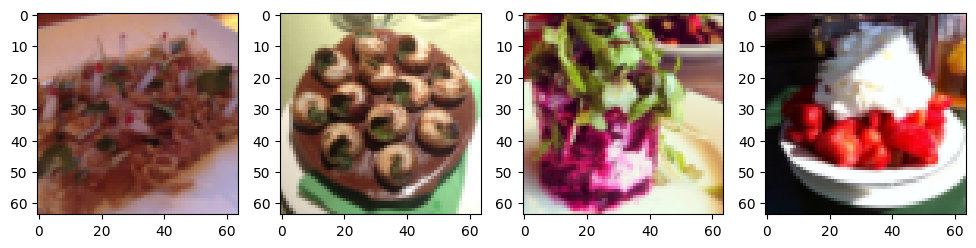

In [8]:
images, labels = next(iter(trainloader))
image_shower(images, labels)

In [9]:
model = torchvision.models.resnet50(pretrained=True)
#заморозим веса
for param in model.parameters():
    param.require = False

model.fc = nn.Linear(2048, len(classes))

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
epochs = 9   #количество эпох (сколько раз будем тренировать)
model.to(device) #переносим нашу модель на GPU

for epoch in range(epochs):
    running_loss = 0.0
    #теперь в цикле проходим по нашему загрузчику данных
    for i, data in tqdm(enumerate(trainloader)):
        #каждый батч тоже помещаем на GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        #сбрасываем накопленный градиент 
        optimizer.zero_grad()
        #прогоняем изображения через модель, чтобы получить предсказание
        outputs = model(inputs)
        #рассчитываем функцию потерь (насколько хорошо предсказали)
        loss = criterion(outputs, labels)
        #считаем градиенты (обратный проход)
        loss.backward()
        #делаем шаг оптимизатора (обновляем веса)
        optimizer.step()

        running_loss += loss.item()

    print ("Epoch {} - Training loss: {} ".format(epoch, running_loss/len(trainloader)))

531it [10:47,  1.22s/it]

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    #переводим модель в режим инференса
    model.eval()
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        #получаем наши предсказания
        _, predicted = torch.max(outputs.data, 1)
        #посчитаем общее количество картинок
        total += labels.size(0)
        #посчитаем количество точно классифицированных картинок
        correct += (predicted == labels).sum().item()
print("Accuracy: %d" %(100 * correct/total))

In [ ]:
images, labels = next(iter(testloader))
image_shower(images, labels)

outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" %classes[predict] for predict in predicted[:4]))